## G-Research Crypto Volatility Forecasting

The objective of the competition was to forecast the short-term returns of 14 different cryptocurrencies, which is notably a difficult task due to the inherent volatility and rapid price fluctuations in the cryptocurrency markets​

In [ ]:
# Install Libraries
!pip install kaggle
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 13.1 MB/s eta 0:00:00


In [ ]:
# Import libraries
import arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Installing dependencies. Upload your kaggle api key .json file **below**

In [ ]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

# Get the data
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c g-research-crypto-forecasting
!unzip g-research-crypto-forecasting.zip

**Files**

* train.csv - The training set
  * timestamp - A timestamp for the minute covered by the row.
  * Asset_ID - An ID code for the cryptoasset.
  * Count - The number of trades that took place this minute.
  * Open - The USD price at the beginning of the minute.
  * High - The highest USD price during the minute.
  * Low - The lowest USD price during the minute.
  * Close - The USD price at the end of the minute.
  * Volume - The number of cryptoasset units traded during the minute.
  * VWAP - The volume weighted average price for the minute.
  * Target - 15 minute residualized returns. See the 'Prediction and Evaluation' section of this notebook for details of how the target is calculated.
* example_test.csv - An example of the data that will be delivered by the time series API.
* example_sample_submission.csv - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.
* asset_details.csv - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.
gresearch_crypto - An unoptimized version of the time series API files for offline work. You may need Python 3.7 and a Linux environment to run it without errors.
* supplemental_train.csv - After the submission period is over this file's data will be replaced with cryptoasset prices from the entire submission period. The current copy has been updated from the original and covers roughly 2/3 of the submission period.


In [ ]:
# Get the datafiles into dataframes
df_asset_details = pd.read_csv('asset_details.csv')
df_train = pd.read_csv('train.csv')

#df_sample_submission = pd.read_csv('example_sample_submission.csv')
#df_test = pd.read_csv('example_test.csv')
#df_supplemental_train = pd.read_csv('supplemental_train.csv')

In [ ]:
df_asset_details.head(20)

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [ ]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2018-01-01 00:01:00,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,2018-01-01 00:01:00,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,2018-01-01 00:01:00,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,2018-01-01 00:01:00,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [ ]:
# Convert the timestamp column to datetime format
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], unit='s')

# Group the DataFrame by Asset_ID
grouped_df = df_train.groupby('Asset_ID')

# Create a dictionary of separate DataFrames for each asset ID
asset_dfs = {asset_id: group for asset_id, group in grouped_df}

# Access a specific asset DataFrame (e.g., Asset_ID = 2)
df_asset_2 = asset_dfs.get(2)

# Print the DataFrame for Asset_ID = 2
print(df_asset_2)

                   timestamp  Asset_ID  Count         Open     High      Low  \
0        2018-01-01 00:01:00         2   40.0  2376.580000  2399.50  2357.14   
8        2018-01-01 00:02:00         2   53.0  2374.553333  2400.90  2354.20   
16       2018-01-01 00:03:00         2   61.0  2371.633333  2401.90  2353.70   
24       2018-01-01 00:04:00         2   95.0  2376.060000  2406.40  2344.00   
32       2018-01-01 00:05:00         2   33.0  2372.656667  2404.60  2343.40   
...                      ...       ...    ...          ...      ...      ...   
24236737 2021-09-20 23:56:00         2   88.0   543.044000   543.19   541.01   
24236751 2021-09-20 23:57:00         2  178.0   540.526000   541.05   538.09   
24236765 2021-09-20 23:58:00         2  100.0   538.640000   539.24   538.00   
24236779 2021-09-20 23:59:00         2  249.0   539.215000   542.70   538.87   
24236793 2021-09-21 00:00:00         2  403.0   542.093333   542.62   539.63   

                Close      Volume      

In [ ]:
unique_asset_ids = df_train['Asset_ID'].unique()
print(unique_asset_ids)

[ 2  0  1  5  7  6  9 11 13 12  3  8 10  4]


In [ ]:
df_asset_1 = asset_dfs.get(1)
df_asset_2 = asset_dfs.get(2)
df_asset_3 = asset_dfs.get(3)
df_asset_4 = asset_dfs.get(4)
df_asset_5 = asset_dfs.get(5)
df_asset_6 = asset_dfs.get(6)
df_asset_7 = asset_dfs.get(7)
df_asset_8 = asset_dfs.get(8)
df_asset_9 = asset_dfs.get(9)
df_asset_10 = asset_dfs.get(10)
df_asset_11 = asset_dfs.get(11)
df_asset_12 = asset_dfs.get(12)
df_asset_13 = asset_dfs.get(13)

* Returns:
Returns refer to the gains or losses generated by an asset over a specific period. They are calculated by taking the percentage change in the price of the asset. Returns indicate the profitability of an investment and are a key metric in evaluating asset performance.

* Volatility:
Volatility measures the degree of variation or dispersion in the returns of an asset. It quantifies the level of risk associated with the asset's price fluctuations. Higher volatility implies greater uncertainty and risk, while lower volatility suggests relative stability.

* Rolling Standard Deviation:
The rolling standard deviation is a statistical measure that calculates the variability or dispersion of returns over a specific rolling window. It provides an estimate of the asset's historical volatility. A larger standard deviation indicates higher volatility, while a smaller standard deviation suggests lower volatility.

* Rolling Mean:
The rolling mean, also known as the moving average, calculates the average returns over a specific rolling window. It provides a measure of the central tendency or average level of returns. The rolling mean can help identify trends or patterns in the asset's performance.

### Price Data

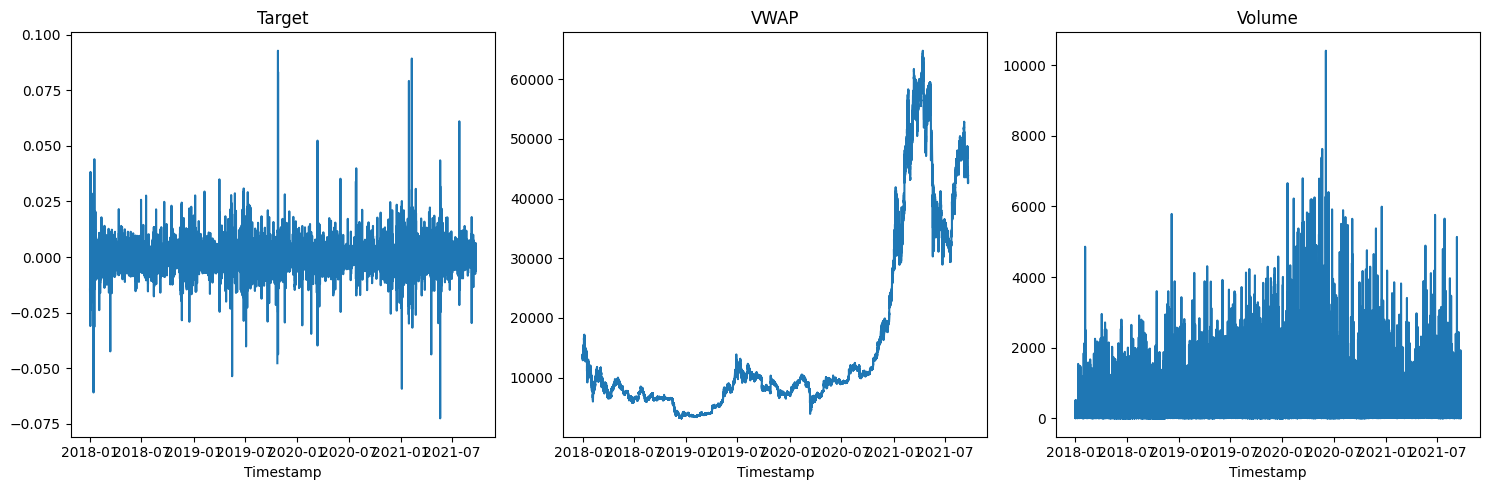

In [ ]:
# Create a figure and axis objects
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the 'Target' series
axs[0].plot(df_asset_1['timestamp'], df_asset_1['Target'])
axs[0].set_title('Target')

# Plot the 'VWAP' series
axs[1].plot(df_asset_1['timestamp'], df_asset_1['VWAP'])
axs[1].set_title('VWAP')

# Plot the 'Volume' series
axs[2].plot(df_asset_1['timestamp'], df_asset_1['Volume'])
axs[2].set_title('Volume')

# Set common x-axis label
for ax in axs:
    ax.set_xlabel('Timestamp')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

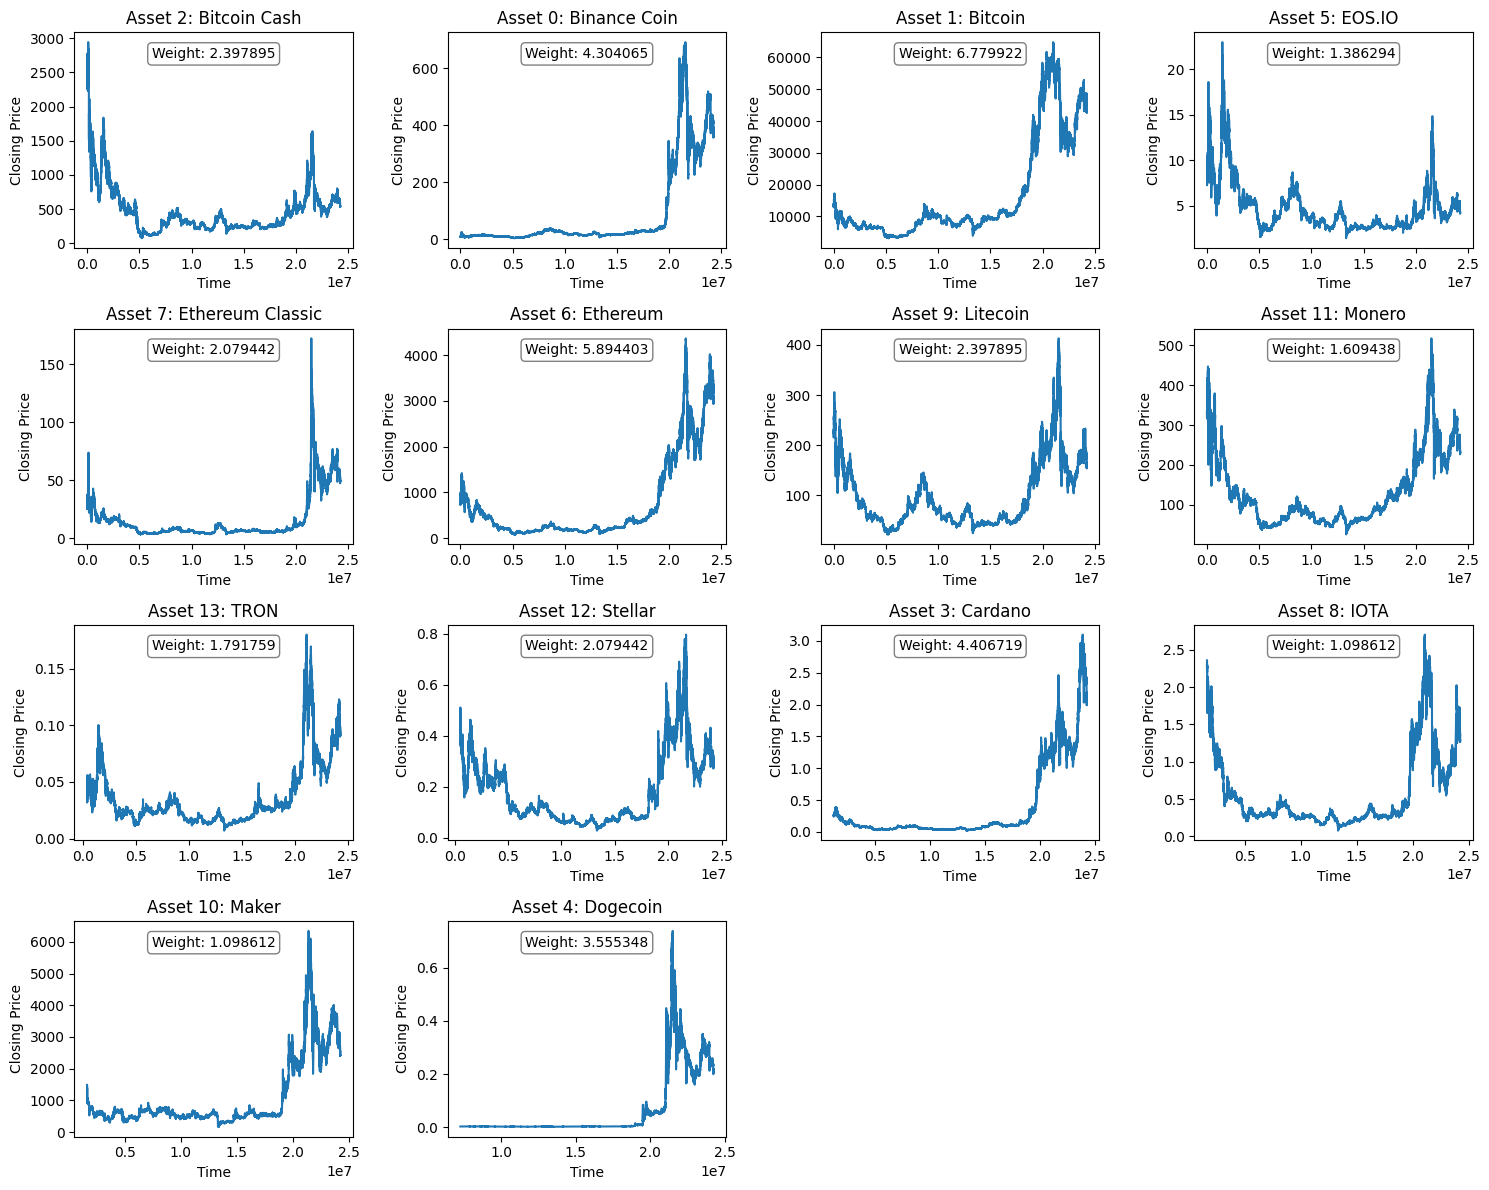

In [ ]:
import matplotlib.pyplot as plt

# Define the asset IDs, weights, and asset names
asset_ids = [2, 0, 1, 5, 7, 6, 9, 11, 13, 12, 3, 8, 10, 4]
weights = [2.397895, 4.304065, 6.779922, 1.386294, 2.079442, 5.894403, 2.397895, 1.609438, 1.791759, 2.079442, 4.406719, 1.098612, 1.098612, 3.555348]
asset_names = ['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO', 'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON', 'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin']

# Set the number of rows and columns in the plot grid
num_rows = 4
num_cols = 4

# Create a new figure and adjust the spacing between subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

# Iterate over the asset IDs and plot the closing price against time with labels
for i, asset_id in enumerate(asset_ids):
    row = i // num_cols
    col = i % num_cols

    # Get the corresponding asset DataFrame
    asset_df = asset_dfs.get(asset_id)

    # Plot the closing price against time with labels
    axes[row, col].plot(asset_df.index, asset_df['Close'])
    axes[row, col].set_title(f'Asset {asset_id}: {asset_names[i]}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Closing Price')

    # Add asset weight as a text annotation
    axes[row, col].text(0.5, 0.9, f'Weight: {weights[i]}', transform=axes[row, col].transAxes,
                        fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

# Remove any unused subplots
for i in range(len(asset_ids), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Display the plot
plt.tight_layout()
plt.show()


### Moving averages

<ipython-input-31-288a79f179d9>:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


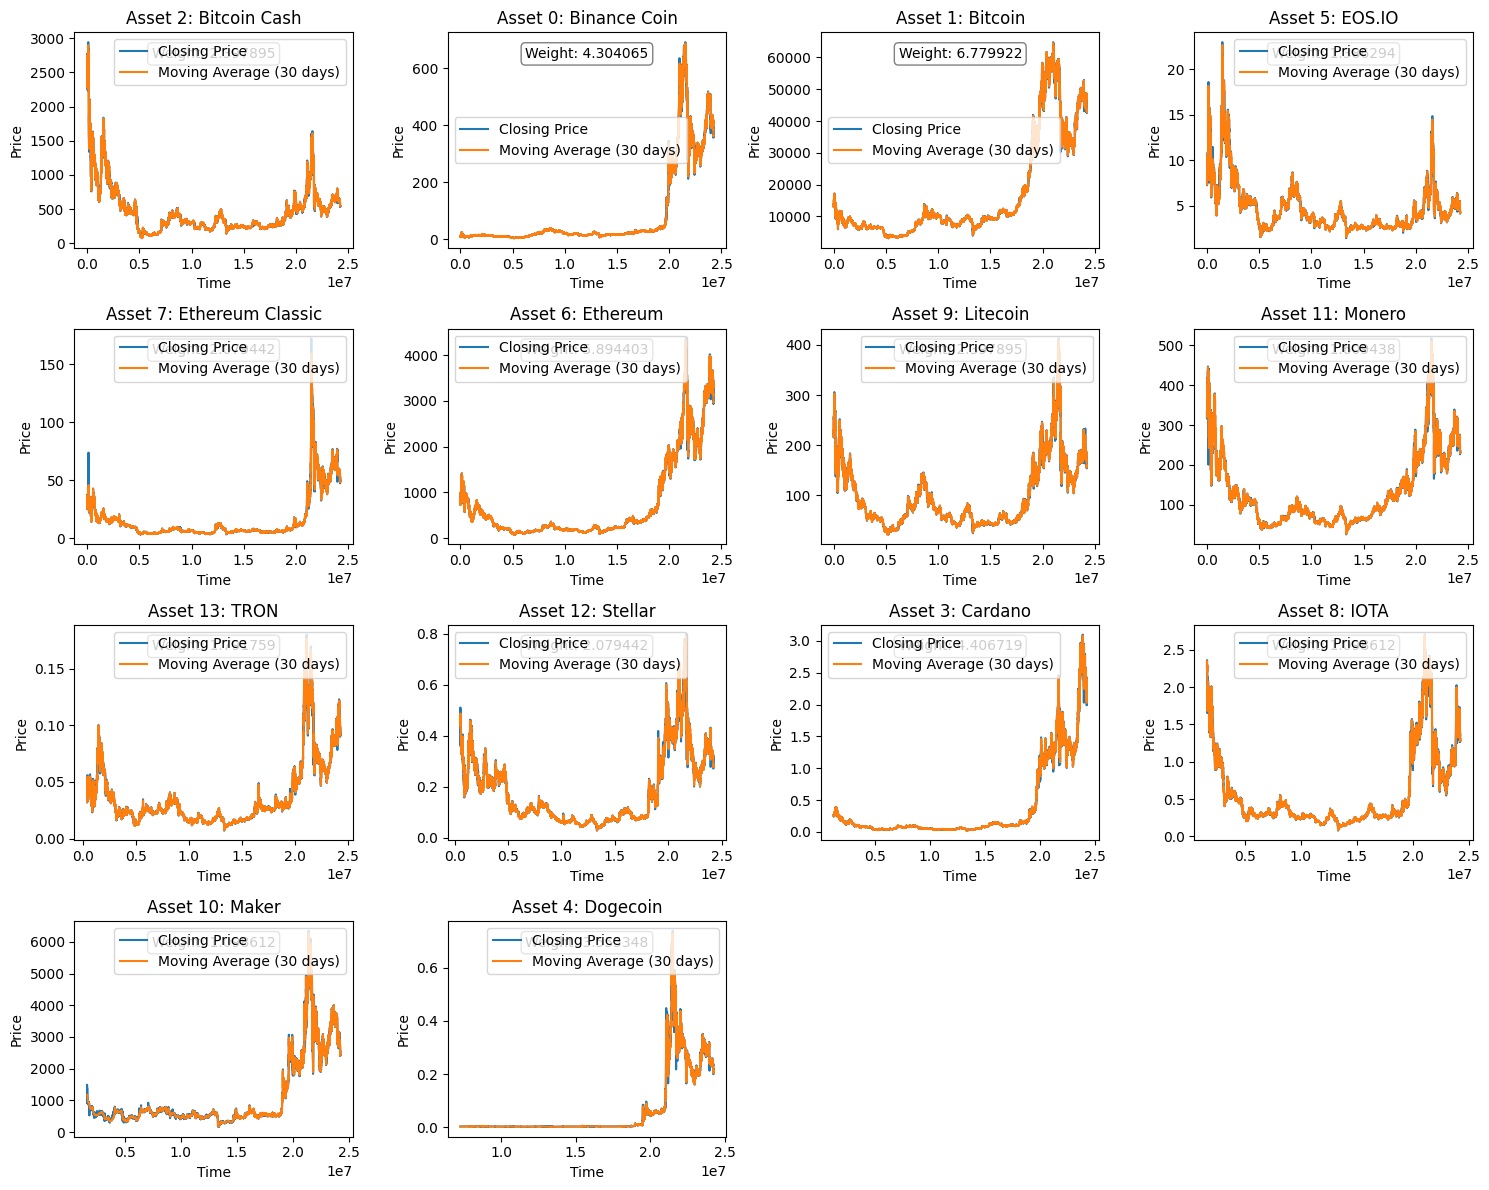

In [ ]:
# Set the number of rows and columns in the plot grid
num_rows = 4
num_cols = 4

# Create a new figure and adjust the spacing between subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

# Iterate over the asset IDs and plot the moving averages against time with labels
for i, asset_id in enumerate(asset_ids):
    row = i // num_cols
    col = i % num_cols

    # Get the corresponding asset DataFrame
    asset_df = asset_dfs.get(asset_id)

    # Calculate the moving average
    ma_window = 30  # Define the moving average window size
    moving_average = asset_df['Close'].rolling(window=ma_window).mean()

    # Plot the closing price and moving average against time with labels
    axes[row, col].plot(asset_df.index, asset_df['Close'], label='Closing Price')
    axes[row, col].plot(asset_df.index, moving_average, label=f'Moving Average ({ma_window} days)')
    axes[row, col].set_title(f'Asset {asset_id}: {asset_names[i]}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Price')

    # Add asset weight as a text annotation
    axes[row, col].text(0.5, 0.9, f'Weight: {weights[i]}', transform=axes[row, col].transAxes,
                        fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

    # Display the legend
    axes[row, col].legend()

# Remove any unused subplots
for i in range(len(asset_ids), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

### Rolling Standard Deviation

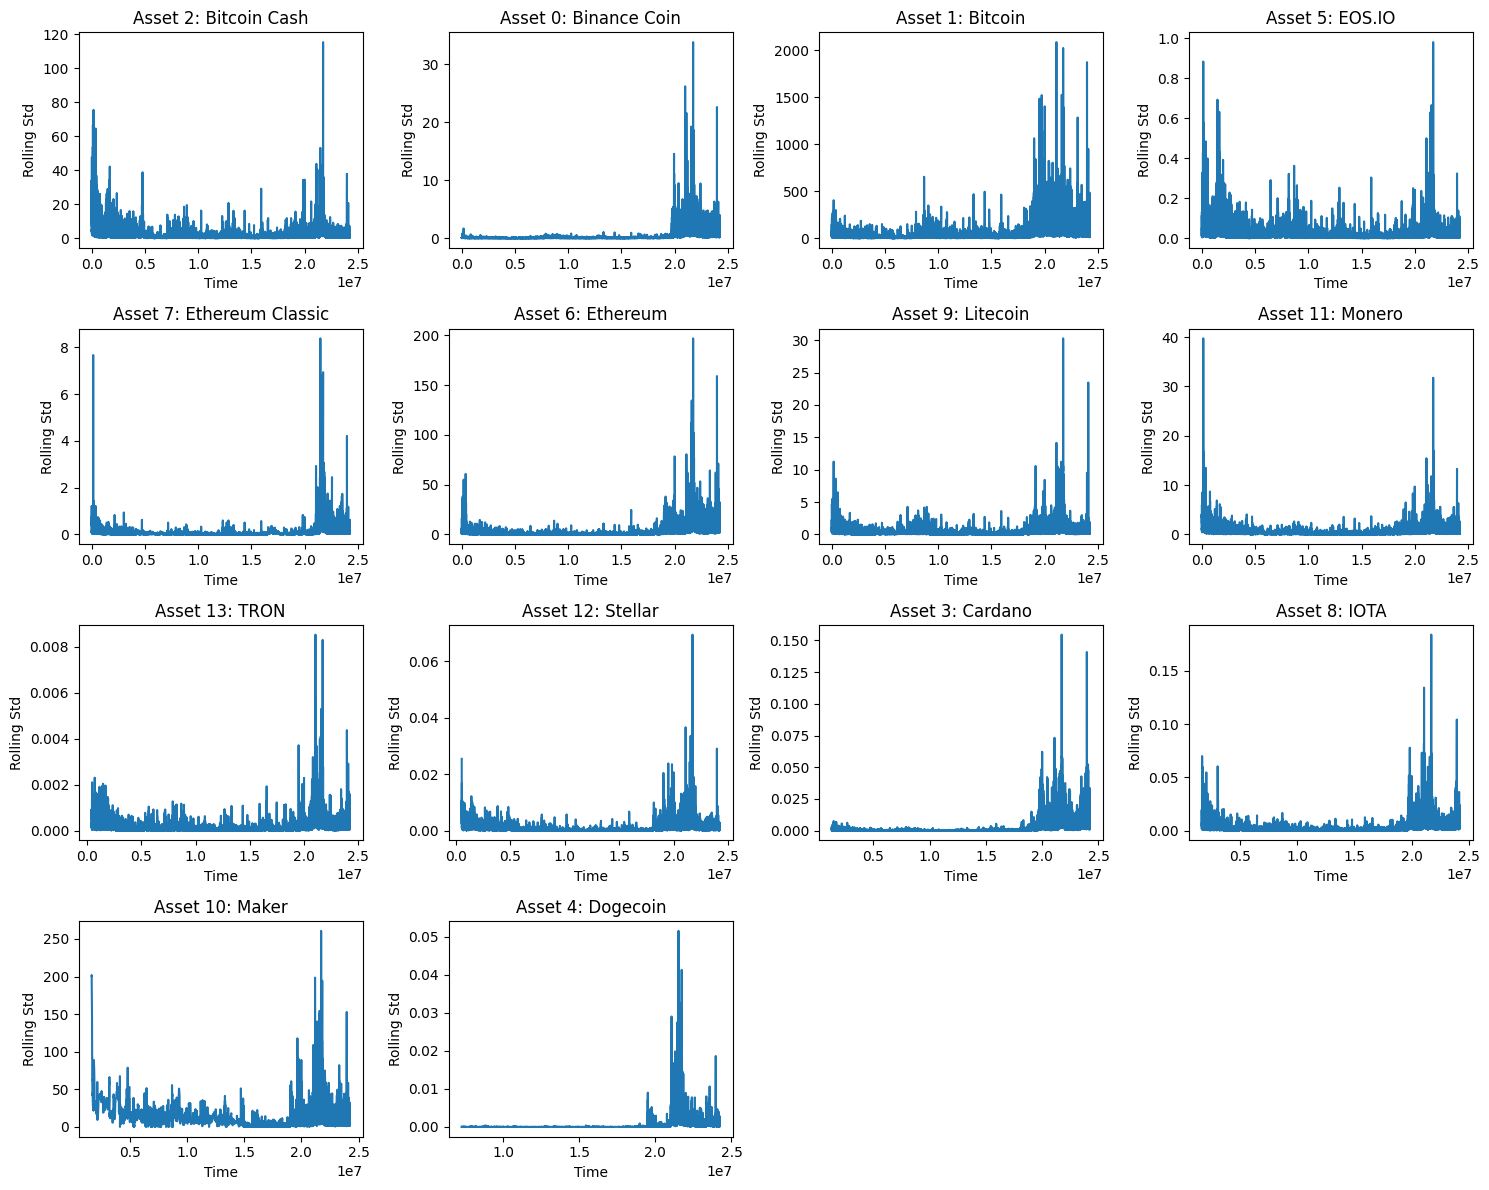

In [ ]:
import matplotlib.pyplot as plt

# Define the asset IDs, weights, and asset names
asset_ids = [2, 0, 1, 5, 7, 6, 9, 11, 13, 12, 3, 8, 10, 4]
weights = [2.397895, 4.304065, 6.779922, 1.386294, 2.079442, 5.894403, 2.397895, 1.609438, 1.791759, 2.079442, 4.406719, 1.098612, 1.098612, 3.555348]
asset_names = ['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO', 'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON', 'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin']

# Set the number of rows and columns in the plot grid
num_rows = 4
num_cols = 4

# Create a new figure and adjust the spacing between subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

# Iterate over the asset IDs and plot the rolling standard deviation of closing prices
for i, asset_id in enumerate(asset_ids):
    row = i // num_cols
    col = i % num_cols

    # Get the corresponding asset DataFrame
    asset_df = asset_dfs.get(asset_id)

    # Calculate the rolling standard deviation of closing prices
    window = 30  # Define the rolling window size
    rolling_std = asset_df['Close'].rolling(window=window).std()

    # Plot the rolling standard deviation of closing prices
    axes[row, col].plot(asset_df.index, rolling_std)
    axes[row, col].set_title(f'Asset {asset_id}: {asset_names[i]}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Rolling Std')

# Remove any unused subplots
for i in range(len(asset_ids), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


### Volatility and Mean Returns

<ipython-input-7-f4e4b84c80bf>:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


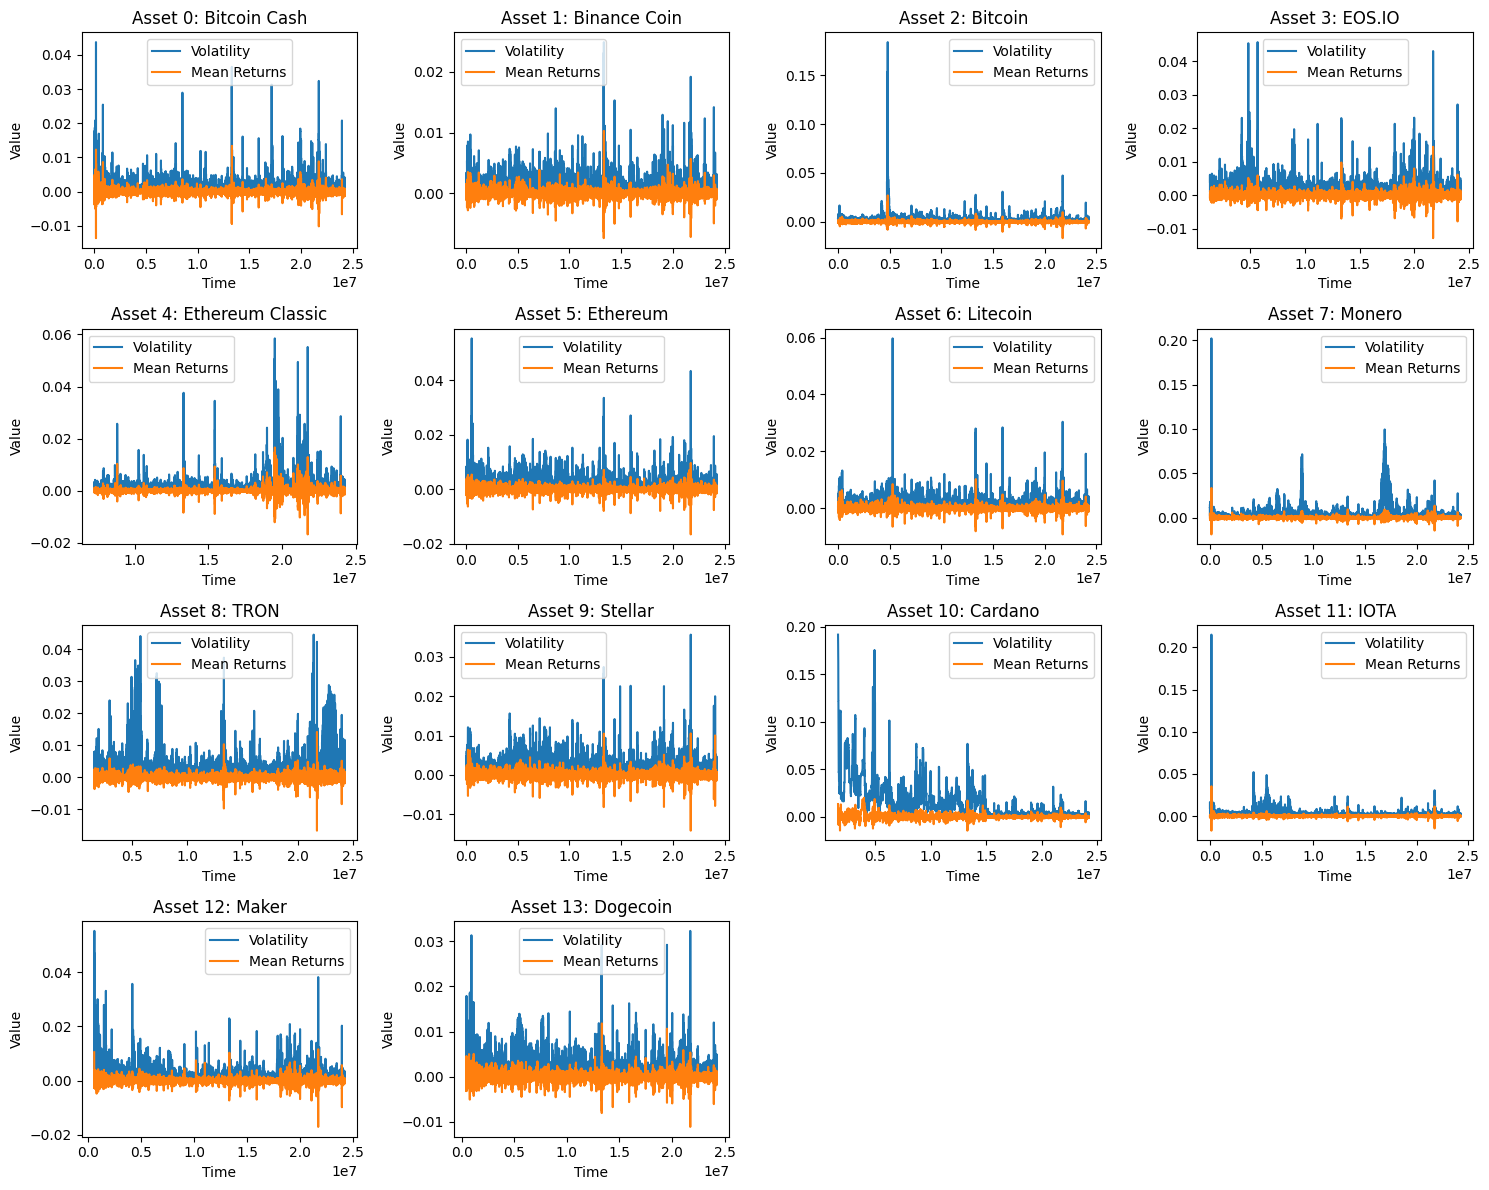

In [ ]:
import matplotlib.pyplot as plt

# Define the asset IDs, weights, and asset names
asset_ids = list(range(14))
weights = [2.397895, 4.304065, 6.779922, 1.386294, 2.079442, 5.894403, 2.397895, 1.609438, 1.791759, 2.079442, 4.406719, 1.098612, 1.098612, 3.555348]
asset_names = ['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO', 'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON', 'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin']

# Set the number of rows and columns in the plot grid
num_rows = 4
num_cols = 4

# Create a new figure and adjust the spacing between subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

# Iterate over the asset IDs and plot the volatility and returns
for i, asset_id in enumerate(asset_ids):
    row = i // num_cols
    col = i % num_cols

    # Get the corresponding asset DataFrame
    asset_df = asset_dfs.get(asset_id)

    # Calculate the returns and rolling standard deviation of returns
    returns = asset_df['Close'].pct_change()
    window = 30  # Define the rolling window size
    rolling_std_returns = returns.rolling(window=window).std()
    rolling_mean_returns = returns.rolling(window=window).mean()

    # Plot the volatility and returns
    axes[row, col].plot(asset_df.index, rolling_std_returns, label='Volatility')
    axes[row, col].plot(asset_df.index, rolling_mean_returns, label='Mean Returns')
    axes[row, col].set_title(f'Asset {asset_id}: {asset_names[i]}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Value')
    axes[row, col].legend()

# Remove any unused subplots
for i in range(len(asset_ids), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 16.3 MB/s eta 0:00:00


ARCH models are used to model time-varying volatility, including volatility clustering and conditional heteroskedasticity. They assist in forecasting volatility, risk management, portfolio optimization, options pricing, and other financial analysis tasks.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.104e-09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -19157866.25560757
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -19157866.23756446
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


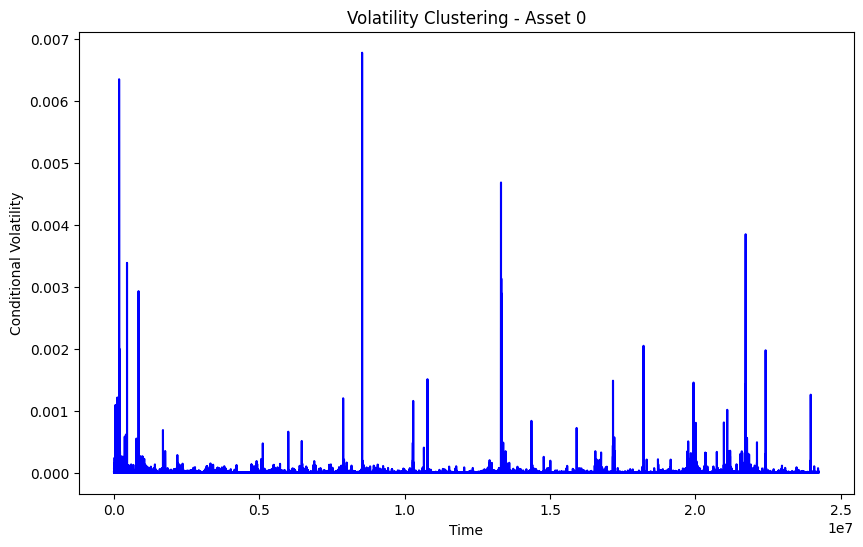

In [ ]:

# Select the asset ID for analysis
asset_id = 0
asset_df = asset_dfs.get(asset_id)

# Calculate squared returns
returns = asset_df['Close'].pct_change().dropna()
squared_returns = returns ** 2

# Estimate GARCH(1,1) model
model = arch.arch_model(squared_returns, vol='Garch', p=1, q=1)
results = model.fit()

# Get conditional volatility
cond_volatility = results.conditional_volatility

# Plot conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(asset_df.index[1:], cond_volatility, color='blue')
plt.title(f'Volatility Clustering - Asset {asset_id}')
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')
plt.show()


The spikes represent periods when the volatility or the level of uncertainty in the asset's returns is relatively high. It indicates that the asset's returns experience larger fluctuations or rapid changes in value during those periods.

ARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are actually more appropriate for volatility clustering analysis than the ARCH model. GARCH models are an extension of ARCH models and provide more flexibility in capturing the dynamics of volatility.

Volatility clustering refers to the phenomenon where periods of high volatility tend to be followed by periods of high volatility, and periods of low volatility tend to be followed by periods of low volatility. In other words, volatility tends to persist in clusters or clusters of high or low volatility.

Conditional volatility refers to the volatility of an asset's returns conditioned on past information. It represents the estimated or predicted volatility at a specific time given the available information up to that point. Conditional volatility captures the time-varying nature of volatility, acknowledging that volatility can change over time.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4891521442211.883
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5267874.558693623
Iteration:      3,   Func. Count:     27,   Neg. LLF: 3190044.9401289434
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3190044.945795432
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9740964762078.72
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2402460.6471089264
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2402460.6552788503
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3674619.972490646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3674619.9378239843
            Iterations: 5
            Funct

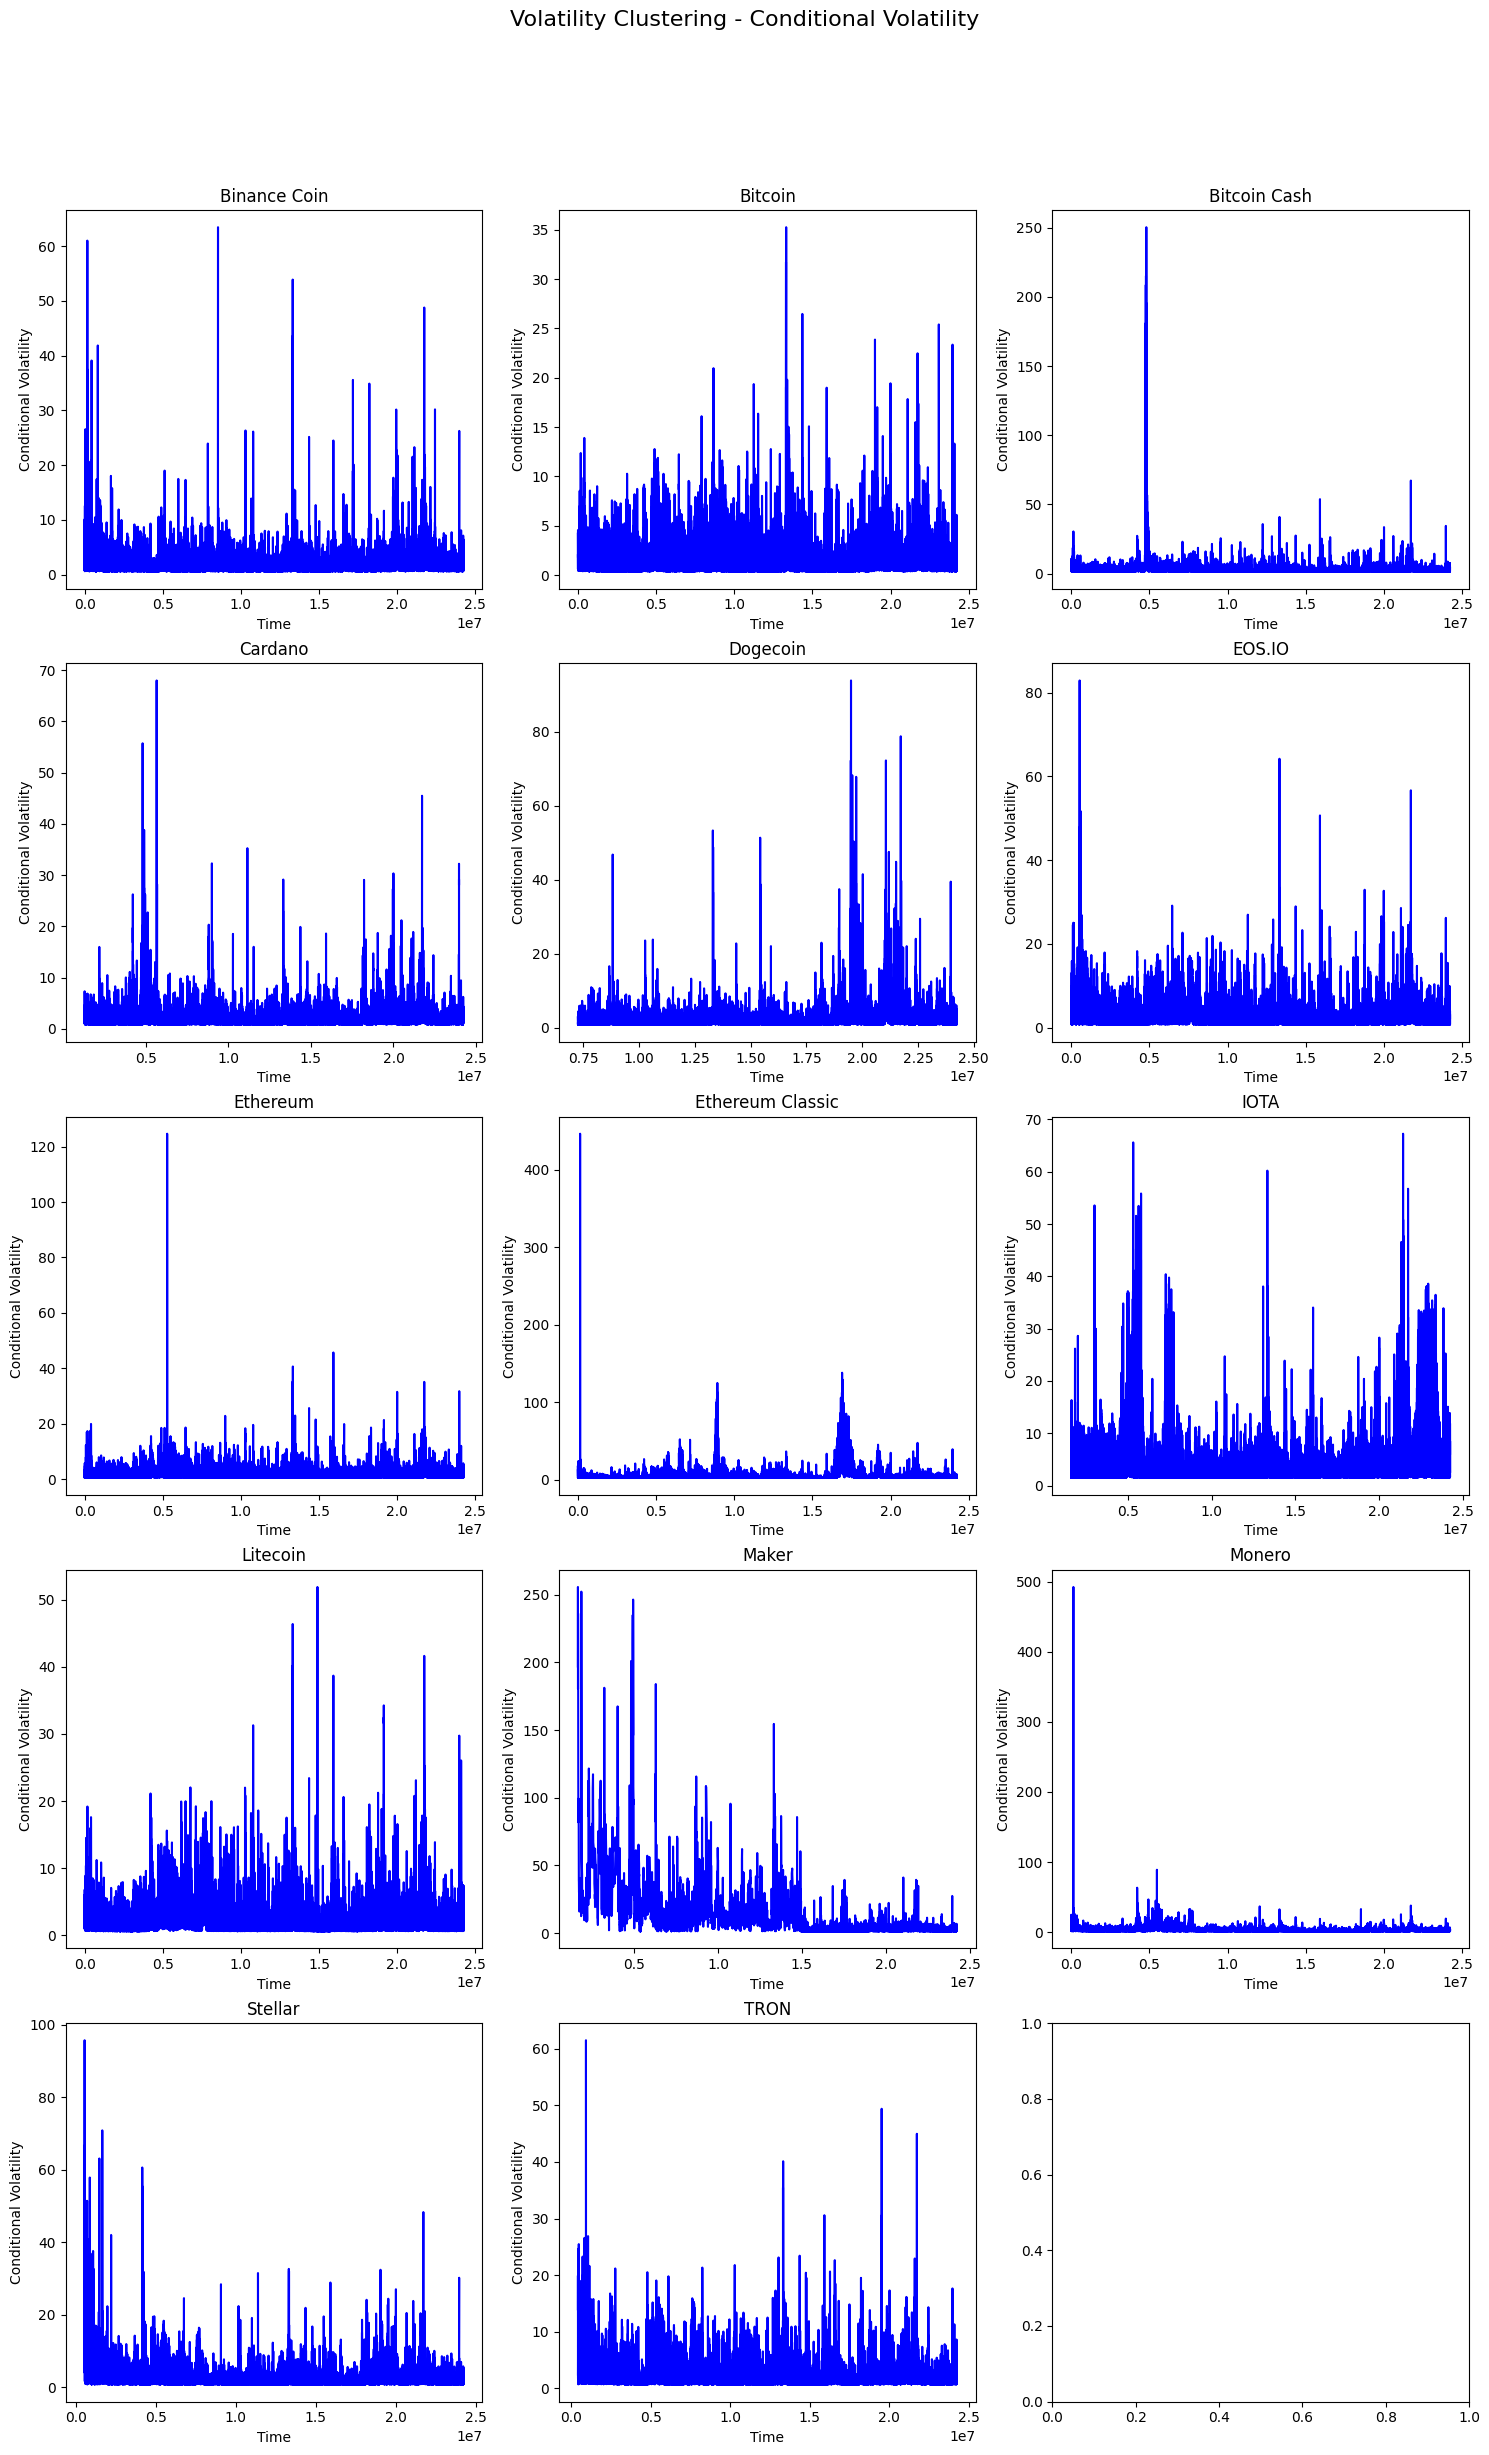

In [ ]:
import arch
import matplotlib.pyplot as plt

# Define asset names and IDs
asset_names = ['Binance Coin', 'Bitcoin', 'Bitcoin Cash', 'Cardano', 'Dogecoin',
               'EOS.IO', 'Ethereum', 'Ethereum Classic', 'IOTA', 'Litecoin',
               'Maker', 'Monero', 'Stellar', 'TRON']
asset_ids = list(range(14))

# Calculate the number of rows and columns for subplots
num_assets = len(asset_ids)
num_rows = int((num_assets + 2) / 3)
num_cols = min(num_assets, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Volatility Clustering - Conditional Volatility', fontsize=16)

# Iterate over each asset ID
for i, asset_id in enumerate(asset_ids):
    asset_df = asset_dfs.get(asset_id)
    asset_name = asset_names[asset_id]

    # Calculate returns and rescale
    returns = asset_df['Close'].pct_change().dropna() * 1000

    # Estimate GARCH(1,1) model
    model = arch.arch_model(returns, vol='Garch', p=1, q=1)
    results = model.fit()

    # Get conditional volatility
    cond_volatility = results.conditional_volatility

    # Plot conditional volatility in the corresponding subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.plot(asset_df.index[1:], cond_volatility, color='blue')
    ax.set_title(asset_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Conditional Volatility')

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()


## Creating a Model

After visualising the data, now we wish to develop a model to forecast volatility for each of these tokens. Based on reading prior studies, it appears that the random forest model is a good place to start.

### Random Forest Model

A Random Forest model is an ensemble learning method that combines multiple decision trees to make predictions.

While decision trees are common supervised learning algorithms, they can be prone to problems, such as bias and overfitting. However, when multiple decision trees form an ensemble in the random forest algorithm, they predict more accurate results, particularly when the individual trees are uncorrelated with each other.
How it works

#### How it works

Random forest algorithms use three main hyperparameters: node size, number of trees, and number of features sampled. They consist of a collection of decision trees, each built on a bootstrap sample from the training set. Feature bagging adds randomness and reduces correlation. For regression, the predictions of individual trees are averaged; for classification, majority voting determines the predicted class. The out-of-bag (oob) sample serves as a test set and cross-validation is performed using it.

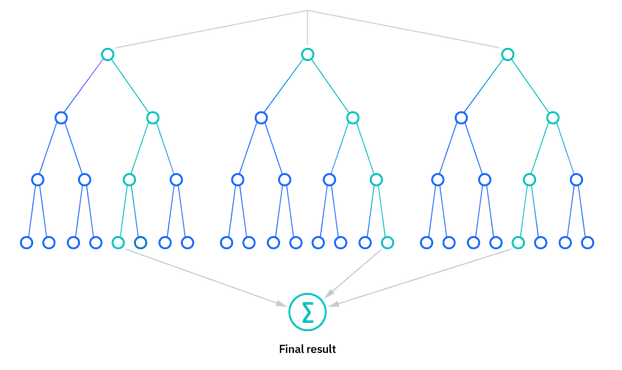

Source: https://www.ibm.com/topics/random-forest

In [ ]:
import pandas as pd


In [ ]:
df_asset_1.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [ ]:
df_asset_6.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
5,2018-01-01 00:01:00,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
13,2018-01-01 00:02:00,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
21,2018-01-01 00:03:00,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
29,2018-01-01 00:04:00,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
37,2018-01-01 00:05:00,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [ ]:
btc = df_asset_1
eth = df_asset_6

In [ ]:
import time
from datetime import datetime

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [ ]:
# Define helper functions
log_return = lambda x, periods: np.log(x / x.shift(periods))
upper_shadow = lambda asset: asset['High'] - np.maximum(asset['Close'], asset['Open'])
lower_shadow = lambda asset: np.minimum(asset['Close'], asset['Open']) - asset['Low']

# Select input features from the trading data for Bitcoin (BTC)
X_btc = pd.concat([
    log_return(btc['VWAP'], periods=5),
    log_return(btc['VWAP'], periods=1).abs(),
    upper_shadow(btc),
    lower_shadow(btc)
], axis=1)
y_btc = btc['Target']

# Select input features from the trading data for Ethereum (ETH)
X_eth = pd.concat([
    log_return(eth['VWAP'], periods=5),
    log_return(eth['VWAP'], periods=1).abs(),
    upper_shadow(eth),
    lower_shadow(eth)
], axis=1)
y_eth = eth['Target']


In [ ]:
X_btc

,VWAP,VWAP,0,1
2,NaN,NaN,163.624000,169.084000
10,NaN,0.000961,217.264000,148.102000
18,NaN,0.002481,176.500000,200.314000
26,NaN,0.001629,196.488000,191.760000
34,NaN,0.003489,189.900000,170.474000
...,...,...,...,...
24236739,0.000074,0.001123,18.070849,20.752857
24236753,-0.001954,0.001303,27.802857,19.845714
24236767,-0.002773,0.000828,28.114286,29.820000
24236781,-0.001061,0.002137,24.882857,20.912802


In [ ]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [ ]:
print(X_btc_train)

[]


In [ ]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Perform standard scaling on the Bitcoin (BTC) training and test sets
X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

# Perform standard scaling on the Ethereum (ETH) training and test sets
X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)


ValueError: ignored

In [ ]:
print(f"{(y_train.isnull().sum() / (len(y_train)))*100 : .3f}% of the training data is invalid")

 0.000% of the training data is invalid


Since so little of the training data is NaN values, we can simply drop those rows for now. If performance is unsatisfactory, then we may consider imputation of the missing values.

In [ ]:
# Concatenate X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Select a subset of the data (e.g., the first n rows)
subset_size = 100000  # Adjust the subset size as needed
subset_data = train_data.head(subset_size)

# Separate the updated feature and target datasets from the subset
X_train_subset = subset_data.drop(columns=['Target'])
y_train_subset = subset_data['Target']

In [ ]:
print(f"{(y_train.isnull().sum() / (len(y_train)))*100 : .3f}% of the training data is invalid")

 0.000% of the training data is invalid


In [ ]:
# Create a random forest regressor object
rf_model = RandomForestRegressor(n_estimators=20, n_jobs=-1,  random_state=42, verbose=2)  # You can adjust the number of trees (n_estimators) as needed

In [ ]:
# Train the random forest model
rf_model.fit(X_train_subset, y_train_subset)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, verbose=2)

In [ ]:
# Make predictions using the trained model
y_pred = rf_model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s finished


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming you have your y_test and y_pred

# Convert y_test and y_pred to pandas Series (if not already)
y_test = pd.Series(y_test)
y_pred = pd.Series(y_pred)

# Align the indices of y_test and y_pred
y_test_aligned, y_pred_aligned = y_test.align(y_pred, join='inner')

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test_aligned, y_pred_aligned)
print("Mean Squared Error:", mse)


Mean Squared Error: 1.2664150612959458e-05


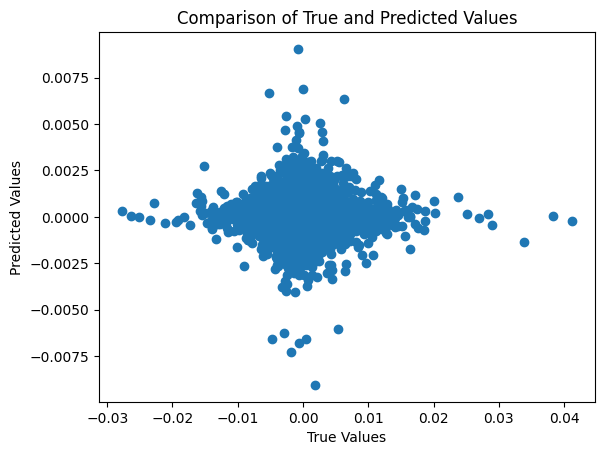

In [ ]:

# Assuming you have your y_test and y_pred

# Create a scatter plot
plt.scatter(y_test_aligned, y_pred_aligned)

# Set labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of True and Predicted Values')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Assuming you have y_test_aligned and y_pred_aligned

# Convert y_test_aligned and y_pred_aligned to pandas Series (if not already)
y_test_aligned = pd.Series(y_test_aligned)
y_pred_aligned = pd.Series(y_pred_aligned)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test_aligned, y_pred_aligned)
print("Mean Squared Error:", mse)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test_aligned, y_pred_aligned)
print("Mean Absolute Error:", mae)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test_aligned, y_pred_aligned, squared=False)
print("Root Mean Squared Error:", rmse)

# Calculate the R-squared score (R2)
r2 = r2_score(y_test_aligned, y_pred_aligned)
print("R-squared Score:", r2)

# Calculate the explained variance score (EVS)
evs = explained_variance_score(y_test_aligned, y_pred_aligned)
print("Explained Variance Score:", evs)


Mean Squared Error: 1.2664150612959458e-05
Mean Absolute Error: 0.0024499666821554467
Root Mean Squared Error: 0.0035586725914249907
R-squared Score: -0.045745557524575986
Explained Variance Score: -0.04516255687153148


R-squared Score (R2): The R2 score measures the proportion of the variance in the target variable that is explained by the model. A negative R2 score of -0.0486 indicates that the model's predictions are performing worse than a simple mean baseline. A positive R2 score closer to 1 would be desirable.

Explained Variance Score (EVS): The EVS measures the proportion of the variance in the target variable that is explained by the model. A negative EVS of -0.0482 suggests that the model is not capturing much of the variance in the data.